# Horapa - Kaprao classification using ResNet152

## Preprocessing data
### Download dataset

In [15]:
# better to manually download the dataset from Github
# because git clone downloads zip files instead of unzip image files
# !git clone https://github.com/TAUTOLOGY-EDUCATION/DATASET

### Import modules

In [16]:
import numpy as np
import pickle
import cv2
from os import listdir
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))



2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Prepare data

In [17]:
# Define constants
width=256
height=256

default_image_size = tuple((width, height))
depth=3

directory_root = './DATASET/HorapaVsKaprao/'

In [18]:
# Convert Image to Array with resizing to square
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            height, width, channels = image.shape

            if height > width:
              image = image[height//2 - width//2:height//2 + width//2, 0:width]
            else:
              image = image[0:height, width//2 - height//2:width//2 + height//2]

            image = cv2.resize(image, default_image_size)

            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [19]:
# Load images
image_list, label_list = [], []

# or you can use image_dataset_from_directory

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)

    for plant_name in root_dir :
        print(f"[INFO] Processing {plant_name} ...")

        plant_image_list = listdir(f"{directory_root}/{plant_name}")

        for image in plant_image_list:
            image_path = f"{directory_root}/{plant_name}/{image}"
            if image_path.endswith(".jpg") or image_path.endswith(".JPG"):
                image_list.append(convert_image_to_array(image_path))
                label_list.append(plant_name)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing horapa ...
[INFO] Processing kaprao ...
[INFO] Image loading completed


In [20]:
# Labeling
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(f"There are {n_classes} classes which is {', '.join(label_binarizer.classes_)}")

There are 2 classes which is horapa, kaprao


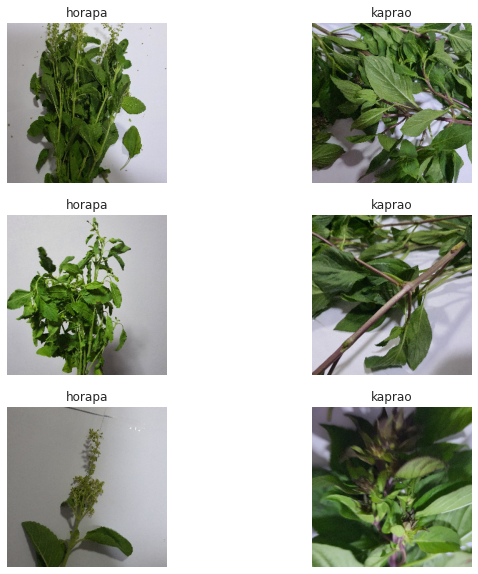

In [21]:
# Preprocessing image
np_image_list = np.array(image_list, dtype=np.float16)

# Show sample of dataset
plt.figure(figsize=(10, 10))

for i in range(6):
  if i % 2 == 0:
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(cv2.cvtColor(image_list[460+i] / 255., cv2.COLOR_BGR2RGB))
    plt.title(label_binarizer.classes_[i%2])
    plt.axis("off")
  else:
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(cv2.cvtColor(image_list[i] / 255., cv2.COLOR_BGR2RGB))
    plt.title(label_binarizer.classes_[i%2])
    plt.axis("off")

In [22]:
# Splitting the data into train, validate, and test set
print("[INFO] Spliting data to train, validate, and test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 2)

print(f"[INFO] All dataset: {len(image_list)}")
print(f"[INFO] Training dataset: {len(y_train)}")
print(f"[INFO] Validation dataset: {len(y_val)}")
print(f"[INFO] Testing dataset: {len(y_test)}")

[INFO] Spliting data to train, validate, and test
[INFO] All dataset: 535
[INFO] Training dataset: 342
[INFO] Validation dataset: 86
[INFO] Testing dataset: 107


In [23]:

# Class weighting
print("[INFO] Class weighting...")
class_weights = class_weight.compute_class_weight(
                                                  'balanced',
                                                  classes=np.unique(np.ravel(y_train, order='C')),
                                                  y=np.ravel(y_train, order='C'))

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

[INFO] Class weighting...
{0: 0.5916955017301038, 1: 3.2264150943396226}


In [24]:
# Data augmentation
aug = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2, 
        zoom_range=0.2,
        horizontal_flip=True, 
        fill_mode="nearest")

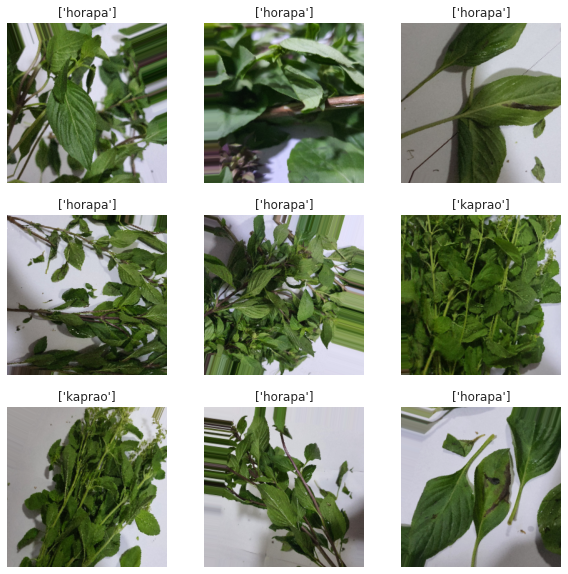

In [25]:
plt.figure(figsize=(10, 10))

image_flow = aug.flow(x_train, y_train, batch_size=BS)

for i in range(9):
  img, label = image_flow.next()
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(cv2.cvtColor(img[0] / 255., cv2.COLOR_BGR2RGB))
  plt.title(label_binarizer.classes_[label[0]])
  plt.axis("off")

## Create model

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, losses, Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [35]:
inputShape = (height, width, depth)

base_model = tf.keras.applications.ResNet152(weights = 'imagenet',
                                             include_top = False, input_shape = inputShape)
for layer in base_model.layers:
  layer.trainable = False
x = layers.Flatten()(base_model.output)
x = layers.Dense(100, activation='relu')(x)
predictions = layers.Dense(1, activation = 'sigmoid')(x)

In [36]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
lr_schedule = LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [37]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer=optimizer, loss=losses.binary_crossentropy, metrics=['accuracy'])

## Training

In [38]:
history = head_model.fit(
            aug.flow(x_train, y_train, batch_size=BS),
            validation_data=(x_val, y_val),
            epochs=EPOCHS,
            verbose=1,
            callbacks=[lr_schedule])

Epoch 1/50
11/11 [==============================] - 13s 632ms/step - loss: 0.7939 - accuracy: 0.6037 - val_loss: 0.8078 - val_accuracy: 0.5930
Epoch 2/50
11/11 [==============================] - 5s 475ms/step - loss: 0.9496 - accuracy: 0.5631 - val_loss: 0.8024 - val_accuracy: 0.6047
Epoch 3/50
11/11 [==============================] - 5s 416ms/step - loss: 0.8052 - accuracy: 0.6675 - val_loss: 0.7965 - val_accuracy: 0.6047
Epoch 4/50
11/11 [==============================] - 5s 424ms/step - loss: 0.8736 - accuracy: 0.6289 - val_loss: 0.7905 - val_accuracy: 0.6047
Epoch 5/50
11/11 [==============================] - 5s 438ms/step - loss: 0.8314 - accuracy: 0.6108 - val_loss: 0.7837 - val_accuracy: 0.6047
Epoch 6/50
11/11 [==============================] - 5s 425ms/step - loss: 0.9115 - accuracy: 0.5658 - val_loss: 0.7762 - val_accuracy: 0.6047
Epoch 7/50
11/11 [==============================] - 5s 412ms/step - loss: 1.0472 - accuracy: 0.4981 - val_loss: 0.7674 - val_accuracy: 0.6163
Epoch

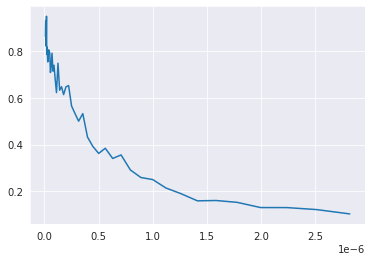

In [39]:
# plot the training results to see the loss against LR
lrs = 1e-8 * 10**(np.arange(EPOCHS)/20)
plt.plot(lrs, history.history["loss"])

Text(0, 0.5, 'Loss')

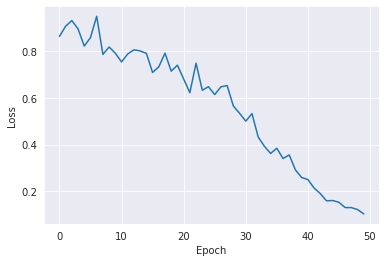

In [40]:
# plot the training loss again
plt.plot(np.arange(len(history.history["loss"])), history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

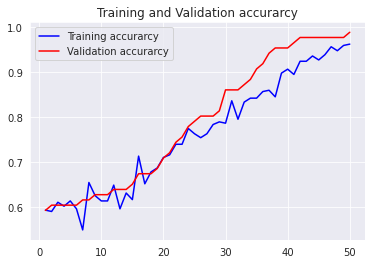

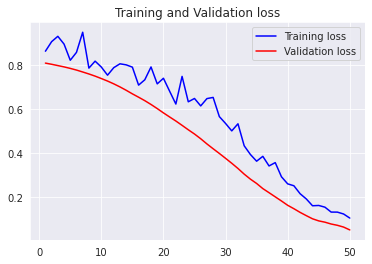

In [41]:
# Show training graph accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [42]:
# Test the model
print("[INFO] Calculating model accuracy")
train_scores = head_model.evaluate(x_train, y_train)
test_scores = head_model.evaluate(x_test, y_test)
all_scores = head_model.evaluate(np_image_list, image_labels)
print(f"Test Accuracy (on train dataset): {train_scores[1]*100}")
print(f"Test Accuracy (on test dataset): {test_scores[1]*100}")
print(f"Test Accuracy (on all dataset): {all_scores[1]*100}")

[INFO] Calculating model accuracy
17/17 [==============================] - 37s 2s/step - loss: 0.0677 - accuracy: 0.9757
Test Accuracy (on train dataset): 97.66082167625427
Test Accuracy (on test dataset): 96.26168012619019
Test Accuracy (on all dataset): 97.57009148597717


Actual is "horapa" and Prediction is "horapa":  90
Actual is "horapa" and Prediction is "kaprao":  1
Actual is "kaprao" and Prediction is "horapa":  3
Actual is "kaprao" and Prediction is "kaprao":  13
Total Correct Prediction: 103 / 107


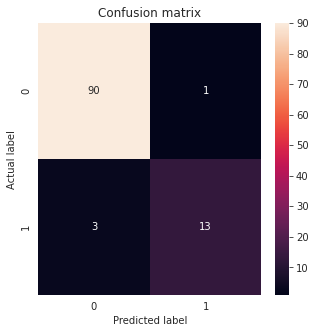

In [43]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(f'Actual is "{label_binarizer.classes_[0]}" and Prediction is "{label_binarizer.classes_[0]}": ', cm[0][0])
    print(f'Actual is "{label_binarizer.classes_[0]}" and Prediction is "{label_binarizer.classes_[1]}": ', cm[0][1])
    print(f'Actual is "{label_binarizer.classes_[1]}" and Prediction is "{label_binarizer.classes_[0]}": ', cm[1][0])
    print(f'Actual is "{label_binarizer.classes_[1]}" and Prediction is "{label_binarizer.classes_[1]}": ', cm[1][1])
    print(f'Total Correct Prediction: {np.sum(cm[0][0] + cm[1][1])} / {np.sum(cm)}')
    

test_predictions_baseline = head_model.predict(x_test, batch_size=BS)

plot_cm(y_test, test_predictions_baseline)

**Save model**

In [45]:
# save the model to disk (too large for Github)
print("[INFO] Saving model...")
head_model.save('saved_model/model-ResNet152.h5')
print('Done')

[INFO] Saving model...
Done
